## Автоматизация отчетности

Предположим, что наш продукт, это приложение с лентой новостей и мессенджер. Мы хотим ежедневно в одно и то же время получать сообщение в Телеграм о показателях за вчерашний день и за предшествующую неделю

Для мониторинга выберем такие метрики, как количество уникальных пользователей (dau) ленты и мессенджера, количество лайков и просмотров, CTR, количество сообщений

In [1]:
# импортируем нужные для работы библиотеки
import telegram
import io
import pandas as pd
import pandahouse as ph
import os
from datetime import datetime, timedelta, date
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

Так как наша база данных учебная, то вскоре она перестанет обновляться, поэтому вместо вчерашнего дня я возьму 23.02.2022, а предшествующие 7 дней будет период с 17.02.2022 по 23.02.2022

Я создала бота в Телеграм, узнала его токен и свой chat_id

In [86]:
# напишем функцию, которая подключается к БД, создает запрос, рассчитывает метрики и отправляет сообщение в личку

def test_report(chat=None):

# задаем переменные даты
    yestarday_day = '2022.02.23'
    seven_days_ago = '2022.02.17'
    last_week = '{} - {}'.format(seven_days_ago, yestarday_day) 
    
# задаем чат, в который будет отправляться сообщение и указываем чат-бота
    chat_id = chat or 1978263659
    bot = telegram.Bot(token='5144799036:AAFdVykhGdzUIiNE9Fj7e8KoHgWZxCodSlg')
    
# подключаемся к БД    
    connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'simulator_20220120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }
    
# создаем запрос, данные ленты за вчерашний день    
    query = "select count(distinct user_id) as dau_feed, countIf(user_id, action = 'view') as views,\
countIf(user_id, action = 'like') as likes, likes / views as CTR from {db}.feed_actions where toDate(time) = '2022.02.23'"
    df_feed_yesterday = ph.read_clickhouse(query, connection=connection)
# создаем запрос, данные мессенджера за вчерашний день    
    query = "select count(distinct user_id) as dau_message, count(user_id) as \
    message from {db}.message_actions where toDate(time) = '2022.02.23' "
    df_message_yesterday = ph.read_clickhouse(query, connection=connection)
# записываем метрики в переменные    
    dau_feed = df_feed_yesterday.dau_feed.iloc[0]
    view_yesterday = df_feed_yesterday.views.iloc[0]
    like_yesterday = df_feed_yesterday.likes.iloc[0]
    ctr_yesterday = df_feed_yesterday.CTR.iloc[0]
    dau_message = df_message_yesterday.dau_message.iloc[0]
    message_yesterday = df_message_yesterday.message.iloc[0]
# отправляем сообщение    
    msg = 'Отчет за {}:\n\nDAU ленты = {} пользователей\nПоказов {}\nЛайков {}\
    \nSTR = {:.2%} \nDAU мессенджера = {}, \nСообщений {}'\
    .format(yestarday_day, dau_feed, view_yesterday, like_yesterday, ctr_yesterday, dau_message, message_yesterday) 
    bot.sendMessage(chat_id=chat_id, text=msg)    
    
# создаем запрос, данные за предыдущие 7 дней по ленте   
    query = "select count(distinct user_id) as dau, countIf(user_id, action = 'view') as view, \
    countIf(user_id, action = 'like') as like, like / view as ctr, toDate(time) as day from {db}.feed_actions \
    where toDate(time) >= '2022.02.17' AND toDate(time) <= '2022.02.23' group by day"
    df_feed = ph.read_clickhouse(query, connection=connection)   
    
# создаем запрос, данные за предыдущие 7 дней по мессенджеру  
    query = "select count(distinct user_id) as dau_mes, count(user_id) as message, \
    toDate(time) as day from {db}.feed_actions \
    where toDate(time) >= '2022.02.17' AND toDate(time) <= '2022.02.23' group by day"
    df_message = ph.read_clickhouse(query, connection=connection)
    
    df = df_feed.merge(df_message, on = 'day')
    
    def get_plot(df):
        fig, axes = plt.subplots(2, 3, figsize = (16, 10))
        fig.suptitle('Статистика за период {}'.format(last_week))
        plot_dict = {(0, 0): {'y': 'dau', 'title': 'Уникальные пользователи ленты'},
                     (0, 1): {'y': 'view', 'title': 'Показы'},
                     (1, 0): {'y': 'like', 'title': 'Лайки'},
                     (1, 1): {'y': 'ctr', 'title': 'CTR'},
                     (0, 2): {'y': 'dau_mes', 'title': 'Уникальные пользователи мессенджера'},
                     (1, 2): {'y': 'message', 'title': 'Сообщения'},
                    }
        for i in range(2):
            for j in range(3):
                sns.lineplot(ax = axes[i, j], data=df, x="day", y=plot_dict[(i, j)]['y'])
                axes[i, j].set_title(plot_dict[(i, j)]['title'])
                axes[i, j].set(xlabel=None)
                axes[i, j].set(ylabel=None)
                for ind, label in enumerate(axes[i, j].get_xticklabels()):
                    if ind % 3 == 0:
                        label.set_visible(True)
                    else:
                        label.set_visible(False)
                            
        plot_object = io.BytesIO()
        plt.savefig(plot_object)
        plot_object.name = 'feed_stat.png'
        plot_object.seek(0)
        plt.close()
        return plot_object
    
    plot_object = get_plot(df)
    bot.sendPhoto(chat_id=chat_id, photo=plot_object)

In [87]:
try:
    test_report()
except Exception as e:
    print(e)

В результате нам в телеграм придет следующее сообщение:

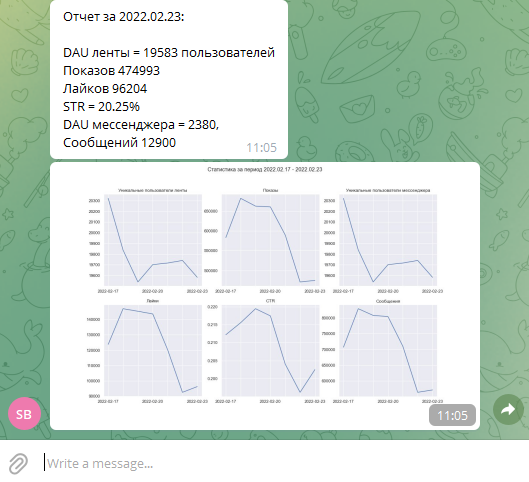

In [88]:
from IPython.display import Image
Image(filename='ris.png') 

Для того, чтобы сообщение приходило к нам каждый день в 9:00 утра настроим расписание CI/CD и создадим .gitlab-ci.yml файл